In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import statsmodels.api as sm
from datetime import datetime, timedelta

from sklearn.model_selection import train_test_split, cross_val_score 
from sklearn.linear_model import LinearRegression 
from sklearn.preprocessing import StandardScaler

# Initial Inspection

In [2]:
# Read in the csv file which contains data
df = pd.read_csv('kc_house_data.csv')

In [3]:
# Let's take a look at the first few columns
df.head()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,7129300520,10/13/2014,221900.0,3,1.00,1180,5650,1.0,NaN,0.0,...,7,1180,0.0,1955,0.0,98178,47.5112,-122.257,1340,5650
1,6414100192,12/9/2014,538000.0,3,2.25,2570,7242,2.0,0.0,0.0,...,7,2170,400.0,1951,1991.0,98125,47.7210,-122.319,1690,7639
2,5631500400,2/25/2015,180000.0,2,1.00,770,10000,1.0,0.0,0.0,...,6,770,0.0,1933,NaN,98028,47.7379,-122.233,2720,8062
3,2487200875,12/9/2014,604000.0,4,3.00,1960,5000,1.0,0.0,0.0,...,7,1050,910.0,1965,0.0,98136,47.5208,-122.393,1360,5000
4,1954400510,2/18/2015,510000.0,3,2.00,1680,8080,1.0,0.0,0.0,...,8,1680,0.0,1987,0.0,98074,47.6168,-122.045,1800,7503


In [4]:
df.dtypes

id                 int64
date              object
price            float64
bedrooms           int64
bathrooms        float64
sqft_living        int64
sqft_lot           int64
floors           float64
waterfront       float64
view             float64
condition          int64
grade              int64
sqft_above         int64
sqft_basement     object
yr_built           int64
yr_renovated     float64
zipcode            int64
lat              float64
long             float64
sqft_living15      int64
sqft_lot15         int64
dtype: object

In [6]:
'''
Get the number of NAs for a DataFrame
'''

def print_NAs(dataframe):
    for column in dataframe:
        num_nas = dataframe[column].isna().sum()
        if num_nas > 0:
            print('Found {0} \t NAs in column \t{1} ({2:0.2f}% of the data)'.format(num_nas, column, 100.*num_nas/len(df)))

print_NAs(df)

Found 2376 	 NAs in column 	waterfront (11.00% of the data)
Found 63 	 NAs in column 	view (0.29% of the data)
Found 3842 	 NAs in column 	yr_renovated (17.79% of the data)


# Plot the waterfront locations on a graph
Not shown here because of library issues but include in powerpoint

In [ ]:
# Since waterfront field is rarely accurately used, let's drop it
df = df.drop(columns=["waterfront"])

In [8]:
# "view" column has empty values, will fill with mode
view_mode = df['view'].mode()
print(view_mode[0])
df['view'].fillna(value=view_mode[0],inplace=True)

0.0


In [9]:
# year renovated is ~18% of the data, 
#Convert year renovated to renovated or not variable
df['is_renovated'] = df['yr_renovated'].apply(lambda x: 1 if x>0 else 0)

In [10]:
#sqft basement is a string and some values are missing '?'
df['sqft_basement'].head(7) 

0       0.0
1     400.0
2       0.0
3     910.0
4       0.0
5    1530.0
6         ?
Name: sqft_basement, dtype: object

In [11]:
# the basement sqft can be calculated as the difference 
# between the living area and the above area
df['sqft_basement'] = df['sqft_living'] - df['sqft_above']

In [12]:
# but since sqft_basement is dependent on two other variables, l
# let's convert it into a has basement or not
df['has_basement'] = df['sqft_basement'].apply(lambda x: 1 if x>0 else 0)


In [14]:
# Looking for outliers

In [15]:
df.bedrooms.unique()

array([ 3,  2,  4,  5,  1,  6,  7,  8,  9, 11, 10, 33])

In [16]:
df[df.bedrooms>30]

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,view,condition,...,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15,is_renovated,has_basement
15856,2402100895,6/25/2014,640000.0,33,1.75,1620,6000,1.0,0.0,5,...,580,1947,0.0,98103,47.6878,-122.331,1330,4700,0,1


In [18]:
# The 33 bedroom house appears to be a typo, removing..
df = df[df.bedrooms<30]

# Questions
### What is the best month / day to sell ?

In [19]:
from datetime import datetime
df['date'] = df['date'].apply(lambda x: datetime.strptime(x,'%m/%d/%Y'))

In [20]:
df['year_bought'] = df['date'].apply(lambda x: x.year)
df['month_bought'] = df['date'].apply(lambda x: x.month)
df['dofweek_bought'] = df['date'].apply(lambda x: x.weekday())

In [21]:
sold_per_month = df.groupby('month_bought')['price'].count()
sm = pd.DataFrame(list(sold_per_month),columns=['Nbought'])#.iloc[0]

sold_per_week = df.groupby('dofweek_bought')['price'].count()
sw = pd.DataFrame(list(sold_per_week),columns=['Nbought'])

In [22]:
sm.index

RangeIndex(start=0, stop=12, step=1)

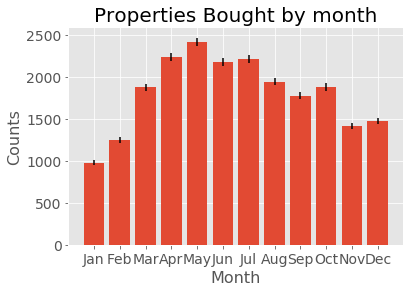

In [23]:

plt.style.use('ggplot')
month_names=['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec']
plt.bar(sm.index, sm.Nbought,yerr = np.sqrt(sm.Nbought)) 
plt.xticks(sm.index,month_names,fontsize=14);
plt.yticks(fontsize=14);
plt.title('Properties Bought by month',fontsize=20);
plt.xlabel('Month', fontsize=16)
plt.ylabel('Counts',fontsize=16);

In [24]:
day_names=['Mon','Tue', 'Wed', 'Thur','Fri','Sat','Sun']

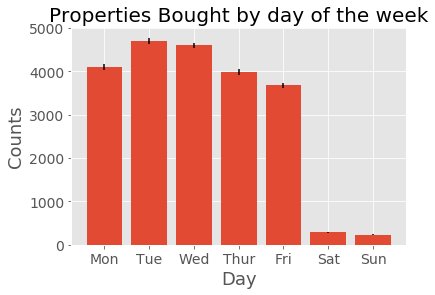

In [25]:
plt.bar(sw.index, sw.Nbought,yerr = np.sqrt(sw.Nbought)) 
plt.xticks(sw.index,day_names,fontsize=14);
plt.yticks(fontsize=14);
plt.title('Properties Bought by day of the week',fontsize=20);
plt.xlabel('Day', fontsize=18)
plt.ylabel('Counts',fontsize=18);

### Most houses are sold on Tuesdays! Who is buying on a weekend?

### New/Renovated Housing vs. Price
Can how recently a house was built or renovated—it's "newness"—affect it's price per square foot?

In [27]:
df["blt_or_renov"] = df["yr_renovated"]
df.loc[df[df["blt_or_renov"] == 0].index, "blt_or_renov"] = df[df["blt_or_renov"] ==0]["yr_built"]
df["blt_or_renov"].fillna(value=df["yr_built"], inplace=True)

In [28]:
df["price_per_sqft"] = df["price"]/df["sqft_living"]

In [30]:
from statsmodels.formula.api import ols
model = ols(formula="price_per_sqft~blt_or_renov", data=df).fit()
#model.summary()

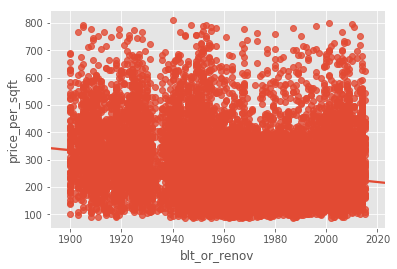

In [31]:
sns.regplot("blt_or_renov","price_per_sqft", data=df)

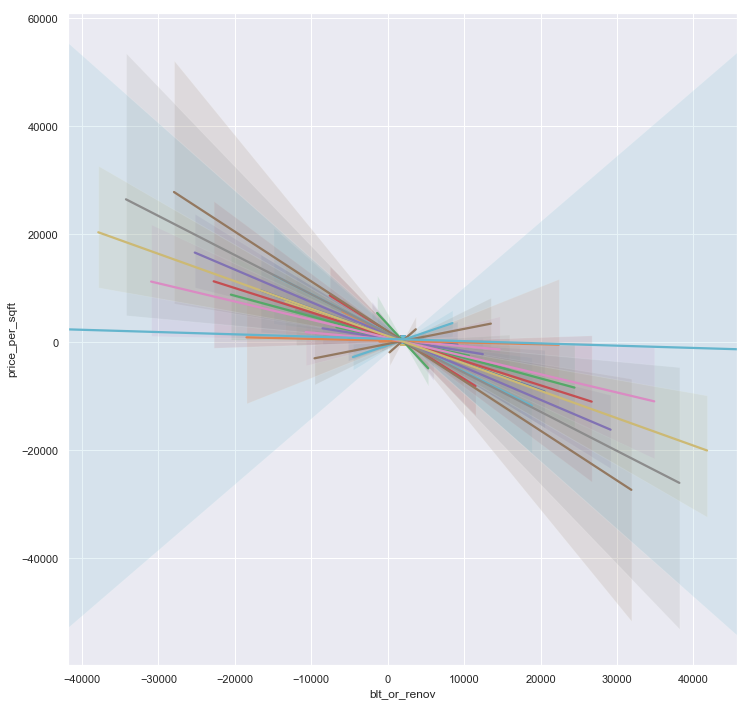

In [33]:
rsquared = {}
slopes = {}

sns.set(rc={'figure.figsize':(12,12)})
for zipcode in df["zipcode"].unique():
    df_filter = df[df["zipcode"] == zipcode]
    model = ols(formula="price_per_sqft~blt_or_renov", data=df_filter).fit()
    sns.regplot("blt_or_renov","price_per_sqft", data=df_filter, label=zipcode)
    rsquared[zipcode] = model.rsquared
    slopes[zipcode] = model.params[1]

In [34]:
print("Top 5 locations where new/renovated housing is cheaper than older. Near Boeing Field airport, Duvall, Renton, Kent, Delridge Except for Delridge, they are all outside downtown Seattle, with Duvall being rural.")
sorted(slopes.items(),key=lambda x:x[1])[0:5]

Top 5 locations where new/renovated housing is cheaper than older. Near Boeing Field airport, Duvall, Renton, Kent, Delridge Except for Delridge, they are all outside downtown Seattle, with Duvall being rural.


[(98075, -1.5333236003573267),
 (98072, -0.9215579923920101),
 (98177, -0.8799497903271822),
 (98019, -0.845068301698574),
 (98042, -0.815741779998186)]

In [35]:
print("The locations where new/renovated housing tends to be more expensive than older. Redmond, WA (home of Microsoft), Bellevue, Washington Park, etc..")
pos_slopes = [x[0] for x in slopes.items() if x[1] > 0]
print(pos_slopes)

The locations where new/renovated housing tends to be more expensive than older. Redmond, WA (home of Microsoft), Bellevue, Washington Park, etc..
[98053, 98007, 98112, 98027, 98166, 98070, 98008, 98144, 98034, 98102, 98029]


Taking a look at the relationship for the zipcode with the largest correlation - 98019.


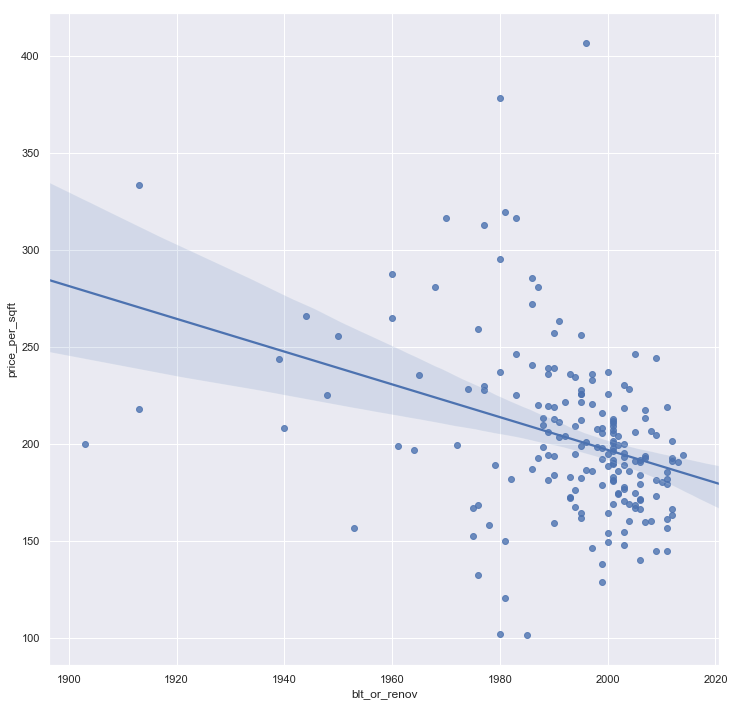

In [36]:
print("Taking a look at the relationship for the zipcode with the largest correlation - 98019.")
sns.regplot("blt_or_renov","price_per_sqft", data=df[df["zipcode"] == 98019], label=zipcode)

Maybe we can ignore pre-1980 housing as there's not much and they appear to be outliers


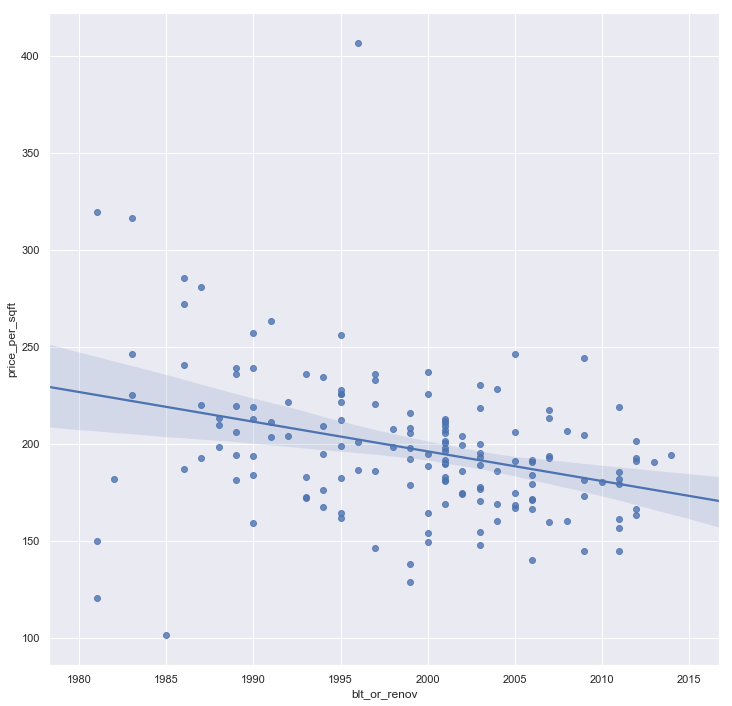

In [37]:
print("Maybe we can ignore pre-1980 housing as there's not much and they appear to be outliers")
sns.regplot("blt_or_renov","price_per_sqft", data=df[(df["zipcode"] == 98019) & (df["blt_or_renov"] >1980)], label=zipcode)

Not a very predictive model but confidence interval bolsters the idea that price per square foot is declining for newer housing in certain zip codes.

In [38]:
df_98019 = df[(df["zipcode"] == 98019) & (df["blt_or_renov"] >1980)]
model = ols(formula="blt_or_renov~price_per_sqft", data=df_98019).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:           blt_or_renov   R-squared:                       0.108
Model:                            OLS   Adj. R-squared:                  0.102
Method:                 Least Squares   F-statistic:                     18.84
Date:                Wed, 08 May 2019   Prob (F-statistic):           2.55e-05
Time:                        09:22:18   Log-Likelihood:                -542.94
No. Observations:                 158   AIC:                             1090.
Df Residuals:                     156   BIC:                             1096.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==================================================================================
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept       2012.8423      3.269    615.824      0.000    2006.386    2019.299
price_per_sqft    -0.0705      0.016     -4.340      0.000      -0.103      -0.038
==============================================================================
Omnibus:                        4.627   Durbin-Watson:                   1.655
Prob(Omnibus):                  0.099   Jarque-Bera (JB):                4.410
Skew:                          -0.408   Prob(JB):                        0.110
Kurtosis:                       3.052   Cond. No.                     1.09e+03
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.09e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

## Modelling whole data set

In [41]:
columns_to_drop = ['id', 'zipcode','lat','long',\
                   'date', 'sqft_basement' , 'yr_renovated','price_per_sqft', 'blt_or_renov']
#'month_bought', 'dofweek_bought', 'waterfront','date']
#columns_to_drop = [ 'yr_renovated','sqft_basement']
#columns_to_drop = [ 'view']
#columns_to_drop = [ 'sqft_lot15', 'sqft_living15']
# columns_to_drop = ['blt_or_renov','price_per_sqft']

In [42]:
df.drop(columns_to_drop, axis=1, inplace=True)

In [43]:
df.head()

,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,view,condition,grade,sqft_above,yr_built,sqft_living15,sqft_lot15,is_renovated,has_basement,year_bought,month_bought,dofweek_bought
0,221900.0,3,1.00,1180,5650,1.0,0.0,3,7,1180,1955,1340,5650,0,0,2014,10,0
1,538000.0,3,2.25,2570,7242,2.0,0.0,3,7,2170,1951,1690,7639,1,1,2014,12,1
2,180000.0,2,1.00,770,10000,1.0,0.0,3,6,770,1933,2720,8062,0,0,2015,2,2
3,604000.0,4,3.00,1960,5000,1.0,0.0,5,7,1050,1965,1360,5000,0,1,2014,12,1
4,510000.0,3,2.00,1680,8080,1.0,0.0,3,8,1680,1987,1800,7503,0,0,2015,2,2


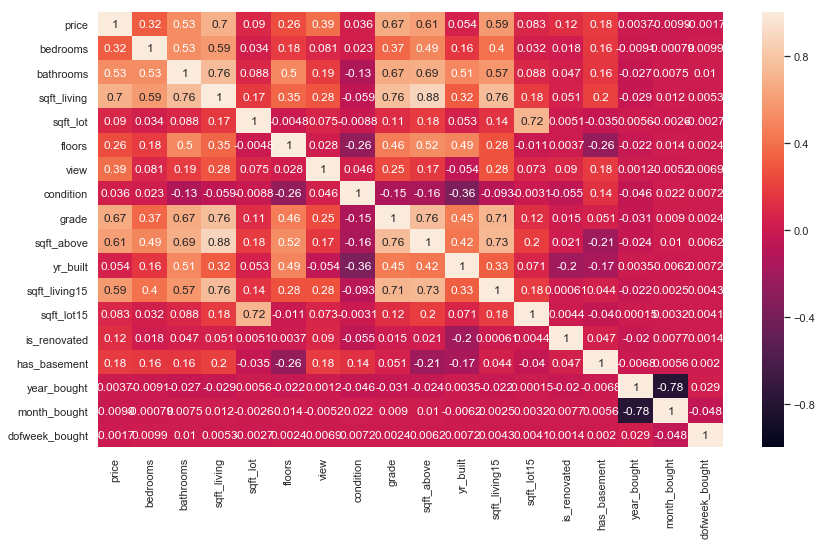

In [44]:
# Let's look at correlations
fig = plt.figure(figsize=(14, 8))
sns.heatmap(df.corr(), annot=True, vmin=-1, vmax=1)

In [45]:
# Dropping additional columns
# year_bought is all effectively 2015
# sqft_living15 and sqft_lot15 only has correlations to sqft, 
# which is a more representative variable
more_cols_to_drop = ['year_bought', 'sqft_lot15', 'sqft_living15']

In [46]:
df.drop(more_cols_to_drop, axis=1, inplace=True)

# Standardize the data

In [49]:
b = df['sqft_living']
df['sqft_living'] = (b-min(b))/(max(b)-min(b))

b = df['sqft_above']
df['sqft_above'] = (b-min(b))/(max(b)-min(b))

b = df['sqft_lot']
df['sqft_lot'] = (b-min(b))/(max(b)-min(b))

b = df['yr_built']
df['yr_built'] = (b-min(b))/(max(b)-min(b))

# standardization
b = df['price']
y = np.log(b)
# price_mean = b.mean()
# price_std = b.std()
# y = (b-price_mean)/(price_std)


In [50]:
# y = df['price']
X = df.drop(columns=['price'])

In [51]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20)
print('Train length ',len(X_train), len(y_train))
print('Test length ',len(X_test), len(y_test))

Train length  17276 17276
Test length  4320 4320


In [79]:
from sklearn.linear_model import LinearRegression
from sklearn.feature_selection import RFE
from sklearn.metrics import mean_squared_error


linreg = LinearRegression()

npred_arr = []
rms_train = []
rms_test=[]
top_predictors = []
for npreds in range(1,len(X_train.columns)):

    selector = RFE(linreg, n_features_to_select = npreds)
    selector = selector.fit(X_train, y_train)
    features_bool = np.array(selector.support_)
    features = np.array(X_train.columns)
    top = features[features_bool]
    print(top)
#    linreg.fit(X_train, y_train)
    y_hat_train = selector.predict(X_train)
    y_hat_test = selector.predict(X_test)
    
    top_predictors.append(top)
    npred_arr.append(npreds)
    train_mse = mean_squared_error(y_train, y_hat_train)
    test_mse = mean_squared_error(y_test, y_hat_test)
    rms_train.append(train_mse)
    rms_test.append(test_mse)

['sqft_living']
['sqft_living' 'sqft_above']
['sqft_living' 'sqft_above' 'yr_built']
['sqft_living' 'grade' 'sqft_above' 'yr_built']
['sqft_living' 'grade' 'sqft_above' 'yr_built' 'has_basement']
['sqft_living' 'floors' 'grade' 'sqft_above' 'yr_built' 'has_basement']
['sqft_living' 'floors' 'view' 'grade' 'sqft_above' 'yr_built'
 'has_basement']
['bathrooms' 'sqft_living' 'floors' 'view' 'grade' 'sqft_above' 'yr_built'
 'has_basement']
['bathrooms' 'sqft_living' 'floors' 'view' 'condition' 'grade'
 'sqft_above' 'yr_built' 'has_basement']
['bathrooms' 'sqft_living' 'floors' 'view' 'condition' 'grade'
 'sqft_above' 'yr_built' 'is_renovated' 'has_basement']
['bathrooms' 'sqft_living' 'sqft_lot' 'floors' 'view' 'condition' 'grade'
 'sqft_above' 'yr_built' 'is_renovated' 'has_basement']
['bedrooms' 'bathrooms' 'sqft_living' 'sqft_lot' 'floors' 'view'
 'condition' 'grade' 'sqft_above' 'yr_built' 'is_renovated' 'has_basement']
['bedrooms' 'bathrooms' 'sqft_living' 'sqft_lot' 'floors' 'view'
 

Text(0, 0.5, 'RMSE')

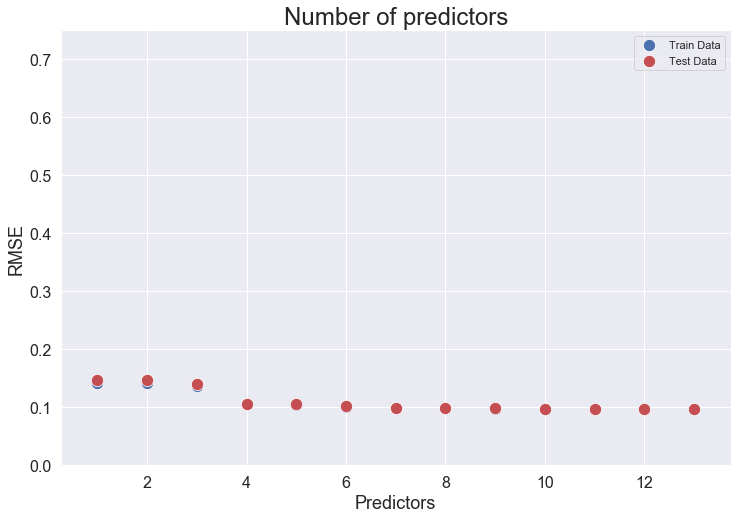

In [80]:
fig = plt.figure(figsize=(12,8))
sns.scatterplot(npred_arr, rms_train,label='Train Data',s=150,color='b')
sns.scatterplot(npred_arr, rms_test,label='Test Data',s=150,color='r')
plt.xlabel('Predictors',fontsize=18)
plt.title('Number of predictors',fontsize=24)

# plt.xticks(npred_arr,X_train.columns,rotation='vertical',fontsize=16)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.ylim(0.0, 0.75)
plt.ylabel('RMSE', fontsize=18)

In [109]:
fields = ['sqft_living', 'floors' ,'view', 'grade', 'sqft_above', 'yr_built',
 'has_basement', 'bathrooms']
model = sm.OLS(y_train, sm.add_constant(X_train[fields])).fit()

In [110]:
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.645
Model:                            OLS   Adj. R-squared:                  0.645
Method:                 Least Squares   F-statistic:                     3916.
Date:                Wed, 08 May 2019   Prob (F-statistic):               0.00
Time:                        10:10:04   Log-Likelihood:                -4487.5
No. Observations:               17276   AIC:                             8993.
Df Residuals:                   17267   BIC:                             9063.
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const           11.1201      0.021    539.946      0.000      11.080      11.160
sqft_living      1.3492      0.137      9.835      0.000       1.080       1.618
floors           0.0953      0.006     15.915      0.000       0.084       0.107
view             0.0645      0.003     19.384      0.000       0.058       0.071
grade            0.2255      0.004     64.004      0.000       0.219       0.232
sqft_above       0.4989      0.105      4.731      0.000       0.292       0.706
yr_built        -0.6328      0.012    -52.465      0.000      -0.656      -0.609
has_basement     0.1187      0.009     13.161      0.000       0.101       0.136
bathrooms        0.0635      0.006     11.426      0.000       0.053       0.074
==============================================================================
Omnibus:                       90.574   Durbin-Watson:                   2.005
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              113.098
Skew:                          -0.097   Prob(JB):                     2.76e-25
Kurtosis:                       3.345   Cond. No.                         584.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [111]:
X_train[fields].head()

,sqft_living,floors,view,grade,sqft_above,yr_built,has_basement,bathrooms
2439,0.120729,1.0,0.0,7,0.094027,0.478261,1,2.50
19322,0.145027,1.0,0.0,7,0.100664,0.147826,1,2.75
4123,0.118451,2.0,0.0,8,0.172566,0.834783,0,2.25
16859,0.083523,1.0,0.0,7,0.121681,0.660870,0,1.50
15294,0.070615,1.0,0.0,7,0.102876,0.391304,0,1.75


In [115]:

y_predict_test = model.predict(sm.add_constant(X_test[fields]))

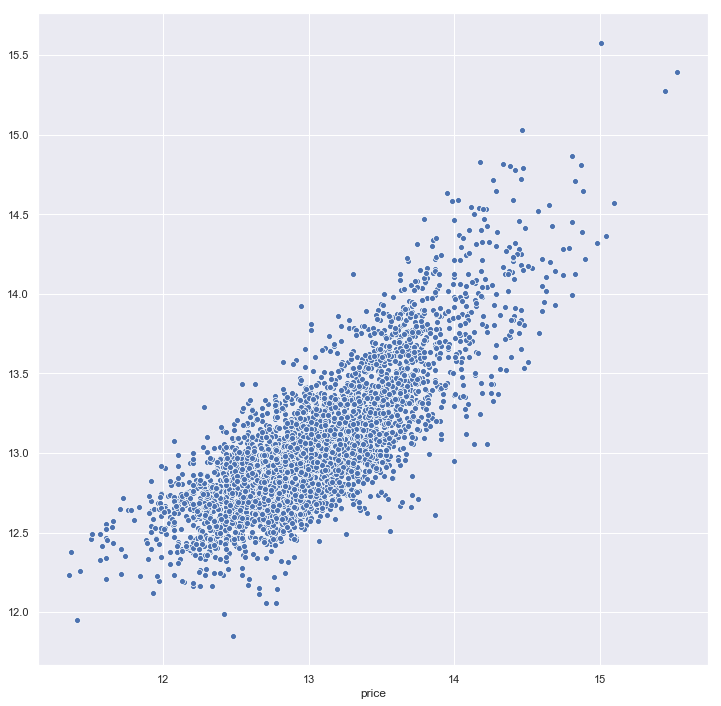

In [116]:
sns.scatterplot(y_test, y_predict_test)

In [118]:
y_predict_train = model.predict(sm.add_constant(X_train[fields]))

/Users/lhinkesjones/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:2389: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


In [119]:
from sklearn.metrics import mean_squared_error
train_mse = mean_squared_error(y_train, y_predict_train)
test_mse = mean_squared_error(y_test, y_predict_test)
print('Train Mean Squarred Error:', train_mse)
print('Test Mean Squarred Error:', test_mse)

Train Mean Squarred Error: 0.09843380056380045
Test Mean Squarred Error: 0.09859898821640095


In [120]:
model.params

const           11.120111
sqft_living      1.349215
floors           0.095265
view             0.064494
grade            0.225550
sqft_above       0.498918
yr_built        -0.632790
has_basement     0.118735
bathrooms        0.063453
dtype: float64

In [125]:
delta_price_per = (np.exp(.0644) - 1)
print(delta_price_per)

0.06651892101977452


In [148]:

print(df.iloc[8]["price"])
print(df[fields].iloc[8])

229500.0
sqft_living     0.107062
floors          1.000000
view            0.000000
grade           7.000000
sqft_above      0.075221
yr_built        0.521739
has_basement    1.000000
bathrooms       1.000000
Name: 8, dtype: float64


In [146]:
model.predict(sm.add_constant(df[fields]))[8]

12.828238381540707

In [147]:
np.exp(12.828238381540707)

372591.6703932243

In [149]:
df2 = df.copy()

In [152]:
df2["view"][8] += 1

/Users/lhinkesjones/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [153]:
df2["view"][8]

1.0

In [154]:
model.predict(sm.add_constant(df2[fields]))[8]

12.892732108201509

In [155]:
np.exp(12.892732108201509)

397413.3127659794

In [156]:
(397413.3127659794 - 372591.670393224)/372591.6703932243

0.06661888696158781